In [1]:
import re
import matplotlib as mpl

import glob
import os
import shutil
import traceback
import json
import cv2
import h5py

import math
import skimage
import time


import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import tifffile as tf
import cPickle as pkl
import matplotlib.colors as mcolors
import sklearn.metrics as skmetrics 
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pipeline.python import utils as putils
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.coregistration import align_fov as coreg
from pipeline.python.classifications import gradient_estimation as grd
from pipeline.python.classifications import aggregate_data_stats as aggr

from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


from skimage.color import label2rgb
#from skimage.measure import label, regionprops, find_contours
import skimage.measure as skmeasure
from skimage.measure import block_reduce


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fil

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/paradigm/tifs_to_data_arrays.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.st

In [2]:
%matplotlib inline

In [3]:
def plot_gradients_in_area(labeled_image, img_az, img_el, grad_az, grad_el, 
                           cmap_phase='nipy_Spectral', contour_color='r',
                           spacing=200, scale=None, width=0.01, headwidth=5):
    '''
    Retinomaps overlaid w/ gradient field, plus average gradient dir.
    '''
    fig, axn = pl.subplots(2,2, figsize=(6,6))

    # Maps ------------
    ax=axn[0, 0]
    im = ax.imshow(img_az,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, shrink=0.7)
    ax.set_title('azimuth')
    ax = overlay_contours(labeled_image, ax=ax, lw=2, lc=contour_color)

    ax=axn[1, 0]
    im = ax.imshow(img_el,  cmap=cmap_phase, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, shrink=0.7)
    ax.set_title('elevation')
    ax = overlay_contours(labeled_image, ax=ax, lw=2, lc=contour_color)

    # Gradients ------------   
    ax=axn[0,0]
    #ax.imshow(thr_img_az, cmap=cmap_phase, vmin=vmin, vmax=vmax)
    grd.plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
                  headwidth=headwidth)
    ax=axn[1, 0]
    #ax.imshow(thr_img_el, cmap=cmap_phase, vmin=vmin, vmax=vmax)
    grd.plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
                  headwidth=headwidth)

    # Unit vectors ------------
    # Get average unit vector
    avg_dir_el = np.rad2deg(grad_el['mean_direction'])
    #print('[EL] avg dir: %.2f deg' % avg_dir_el)
    vhat_el = grad_el['vhat']
    avg_dir_az = np.rad2deg(grad_az['mean_direction'])
    #print('[AZ] avg dir: %.2f deg' % avg_dir_az)
    vhat_az = grad_az['vhat']

    ax= axn[0,1]
    ax.grid(True)
    vh = grad_az['vhat'].copy()
    edir_str = "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], avg_dir_az)
    ax.set_title('azimuth\n%s' % edir_str)
    ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
              units='xy', angles='xy', width=.05, pivot='tail')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_aspect('equal')
    ax.invert_yaxis()

    ax = axn[1,1]
    ax.grid(True)
    edir_str = "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], avg_dir_el)
    ax.set_title('elevation\n%s' % edir_str)
    ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
              units='xy', angles='xy', width=.05, pivot='tail')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_aspect('equal')
    ax.invert_yaxis()
    
    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig

In [4]:
def plot_segmentation_steps(img_az, img_el, surface=None, O=None, S_thr=None, sign_map_thr=None, 
                           cmap='viridis', labeled_image=None, region_props=None):

    fig, axf = pl.subplots(2, 3, figsize=(8,8))
    axn = axf.flat

    ax=axn[0]; #ax.set_title(proc_info_str, loc='left', fontsize=12)
    im0 = ax.imshow(surface, cmap='gray'); ax.axis('off');

    ax=axn[1]
    im0 = ax.imshow(img_az, cmap=cmap); ax.axis('off');
    putils.colorbar(im0, label='az')

    ax=axn[2]
    im0 = ax.imshow(img_el, cmap=cmap); ax.axis('off');
    putils.colorbar(im0, label='el')

    ax=axn[3]; ax.set_title('Sign Map, O');
    im0 = ax.imshow(O, cmap='jet'); ax.axis('off');

    ax=axn[4]; ax.set_title('Visual Field Patches\n(std_thr=%.2f)' % sign_map_thr)
    im = ax.imshow(S_thr, cmap='jet'); ax.axis('off');

    cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.02])
    cbar_ticks = np.linspace(-1, 1, 5)
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=cbar_ticks)
    cbar_ax.tick_params(size=0)

    ax = axn[5]
    ax.imshow(labeled_image)
    for ri, region in enumerate(region_props): 
        ax.text(region.centroid[1], region.centroid[0], 
                '%i' % region.label, fontsize=24, color='k')
    for index in np.arange(0, len(region_props)):
        label = region_props[index].label
        contour = skmeasure.find_contours(labeled_image == label, 0.5)[0]
        ax.plot(contour[:, 1], contour[:, 0], 'w')
    ax.set_title('Labeled (%i patches)' % len(region_labels))
    ax.axis('off')

    return fig


In [5]:
def segment_areas(img_az, img_el, sign_map_thr=0.5, min_region_area=500, surface=None):
    # Calculate gradients
    # ---------------------------------------------------------
    h_map = img_el.copy()
    v_map = img_az.copy()
    [h_gy, h_gx] = np.array(grd.gradient_phase(h_map))
    [v_gy, v_gx] = np.array(grd.gradient_phase(v_map))

    h_gdir = np.arctan2(h_gy, h_gx) # gradient direction
    v_gdir = np.arctan2(v_gy, v_gx)

    # Create sign map
    # ---------------------------------------------------------
    gdiff = v_gdir-h_gdir
    gdiff = (gdiff + math.pi) % (2*math.pi) - math.pi

    #O=-1*np.sin(gdiff)
    O=np.sin(gdiff) # LEFT goes w/ BOTTOM.  RIGHT goes w/ TOP.
    S=np.sign(O) # Discretize into patches

    # Calculate STD, and threshold to separate areas (simple morph. step)
    # ---------------------------------------------------------
    O_sigma = np.nanstd(O)
    S_thr = np.zeros(np.shape(O))
    S_thr[O>(O_sigma*sign_map_thr)] = 1
    S_thr[O<(-1*O_sigma*sign_map_thr)] = -1
    
    return O, S_thr

def segment_and_label(S_thr):

    # Create segmented + labeled map
    # ---------------------------------------------------------
    filled_smap = grd.fill_nans(S_thr)
    labeled_image_tmp, n_labels = skmeasure.label(
                                 filled_smap, background=0, return_num=True)

    image_label_overlay = label2rgb(labeled_image_tmp) #, image=segmented_img) 
    print(labeled_image_tmp.shape, image_label_overlay.shape)
    rprops_ = skmeasure.regionprops(labeled_image_tmp, filled_smap)
    region_props = [r for r in rprops_ if r.area > min_region_area]
    
    # Relabel image
    labeled_image = np.zeros(labeled_image_tmp.shape)
    for ri, rprop in enumerate(region_props):
        new_label = int(ri+1)
        labeled_image[labeled_image_tmp==rprop.label] = new_label
        rprop.label = new_label
        region_props[ri] = rprop
        
    return region_props, labeled_image 

In [6]:
def load_segmentation_results(animalid, session, fov, retinorun='retino_run1', rootdir='/n/coxfs01/2p-data'):
    results_fpath = os.path.join(rootdir, animalid, session, fov, retinorun, 
                              'retino_analysis', 'segmentation', 'results.pkl')
    
    assert os.path.exists(results_fpath), "Segmentation not found: %s" % results_fpath
    with open(results_fpath, 'r') as f:
        seg_areas = pkl.load(f)
        
    return seg_areas


def load_roi_assignments(animalid, session, fov, retinorun='retino_run1', rootdir='/n/coxfs01/2p-data'):
    
    results_fpath = os.path.join(rootdir, animalid, session, fov, retinorun, 
                              'retino_analysis', 'segmentation', 'roi_assignments.pkl')
    
    assert os.path.exists(results_fpath), "Assignment results not found: %s" % results_fpath
    with open(results_fpath, 'rb') as f:
        r_ = pkl.load(f)
    roi_assignments = r_['roi_assignments']
    roi_masks_labeled = r_['roi_masks_labeled']
    
    return roi_assignments, roi_masks_labeled

In [7]:
def get_gradients_in_area(curr_segmented_mask, img_az, img_el):
    thr_img_az = img_az.copy()
    thr_img_az[curr_segmented_mask==0] = np.nan
    grad_az = grd.calculate_gradients(thr_img_az)

    thr_img_el = img_el.copy()
    thr_img_el[curr_segmented_mask==0] = np.nan
    grad_el = grd.calculate_gradients(thr_img_el)

    return grad_az, grad_el

In [8]:
def overlay_contours(labeled_image, ax=None, lc='w', lw=2):
    if ax is None:
        fig, ax = pl.subplots()
    
    label_ids = [l for l in np.unique(labeled_image) if l!=0]
    #print(label_ids)
    for label in label_ids: # range(1, labeled_image.max()):
        #contour = skmeasure.find_contours(labeled_image == label, 0.5)[-1]
        #print(label, len(contour))
        #ax.plot(contour[:, 1], contour[:, 0], lc, lw=lw)
        contours = skmeasure.find_contours(labeled_image, level=label)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], lc, lw=lw)

    return ax

#### Area assignment functions

In [9]:
def get_transformed_rois(animalid, session, fov, retinorun='retino_run1', 
                        roi_id=None, traceid='traces001'):
    if roi_id is None:
        roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
    roi_masks, zprog_img = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
    print("Loaded rois: %s" % roi_id)
    d1, d2, nrois = roi_masks.shape

    pixel_size = putils.get_pixel_size()    
    # pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
    roi_masks_tr = np.dstack([coreg.transform_2p_fov(roi_masks[:, :, i].astype(float), pixel_size) \
                   for i in np.arange(0, nrois)]) # transform/orient
    roi_masks = roi_masks_tr.astype(bool).astype(int)
    
    return roi_masks


In [10]:
def label_roi_masks(seg_results, roi_masks):
    d1, d2, nrois = roi_masks.shape
    print("Roi masks:", d1, d2, nrois)
    roi_list = [roi_masks[:, :, r] for r in np.arange(0, nrois)] # list makes calc faster
    
    #print(seg_mask.shape)
    
    label_keys = seg_results['label_keys']
    roi_assignments={}
    for area_name, seg in seg_results['areas'].items():
#         if putils.isnumeric(area_name):
#             continue
        seg_mask = cv2.resize(seg['mask'], (d2, d1))
        id_mask = seg['id'] * seg_mask
        incl_rois = np.array([int(i) for i, rmask in enumerate(roi_list) if (id_mask*rmask).max()==seg['id']])
        roi_assignments[area_name]=list(incl_rois)

        # assign label to masks
        if len(incl_rois)>0:
            roi_masks[:,:,incl_rois] *= seg['id']
    
    return roi_assignments, roi_masks


In [11]:
def assign_rois_to_visual_area(animalid, session, fov, retinorun='retino_run1',roi_id=None, 
                                traceid='traces001', return_labeled_masks=False, verbose=False):

    # Load ROIs
    roi_masks = get_transformed_rois(animalid, session, fov, retinorun=retinorun, 
                                     traceid=traceid)
    d1, d2, nrois = roi_masks.shape

    # Load segmentation results
    seg_results = roi_utils.load_segmentation_results(animalid, session, fov, retinorun=retinorun)

    # Assign each ROI to visual areas
    roi_assignments, roi_masks_labeled = label_roi_masks(seg_results, roi_masks.astype(int))

    if verbose:
        for v, r in roi_assignments.items():
            print("%s: %i cells" % (v, len(r)))

    if return_labeled_masks:
        return roi_assignments, roi_masks_labeled
    else:
        return roi_assignments


In [12]:
def plot_roi_area_mask_overlay(labeled_image, region_props, roi_masks=None, roi_int_img=None, 
                               surface=None, ax=None, cmap='hsv'):
    '''
    One of roi_masks or roi_ints must NOT be None.
    
    roi_masks: 3d array of masks (d1, d2, nrois)
    roi_ints: same shape as roi_masks, but 1's are assigne integer values for plotting (None, will be sequential)

    labeled_image: image with assigned segmentations
    region_props: oputput of skimage.measure.region_props() on gradient/signed maps
    '''
    if ax is None:
        f, ax = pl.subplots() 
    
    if roi_masks is not None:
        d1, d2, nrois = roi_masks.shape
    else:
        d1, d2 = roi_int_img.shape
        
    if surface is None:
        surface = np.zeros((d1, d2))
        
    if roi_int_img is None:
        print("Rando assigning ints to rois")
        roi_int_img = roi_utils.assign_int_to_masks(roi_masks)
    
    vmin=labeled_image.min()
    vmax=labeled_image.max()
    print(vmin, vmax)
    
    roi_utils.plot_roi_overlay(roi_int_img, surface, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    ax = overlay_contours(labeled_image, ax=ax, lw=2, lc='w')

    return ax


def add_id_legend(label_keys, ax, cmap='viridis', bbox_to_anchor=(1,1)):
    label_ids = [v[1] for v in label_keys]
    vmin, vmax = 0, max(label_ids)
    
    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    id_colors = [cmap(norm(i)) for (n, i) in label_keys]
    id_names = [n for (n, i) in label_keys]
    lhandles = putils.custom_legend_markers(colors=id_colors, labels=id_names)
    ax.legend(handles=lhandles, bbox_to_anchor=bbox_to_anchor)


In [13]:
def plot_segmented_rois(seg_results, roi_assignments, roi_masks_labeled, cmap='viridis', 
                        surface=None, ax=None, random_labels=False):

    labeled_image = seg_results['labeled_image']
    region_props = seg_results['region_props']
    label_keys = seg_results['label_keys']
    segmented_areas = seg_results['areas']
        
    d1, d2, nrois = roi_masks.shape
    all_ids = [i for i in np.unique(labeled_image) if i>0]
    
    # Plot rois on visual areas
    roi_int_img = np.zeros((d1, d2))
    for ri in np.arange(0, nrois):
        curr_msk = roi_masks_labeled[:, :, ri].copy()
        if random_labels:
            roi_int_img[curr_msk>0] = (ri+1) #curr_msk.max()
        else:
            found_id = curr_msk.max()
            if found_id in all_ids:
                roi_int_img[curr_msk>0] = found_id
    # plot
    if ax is None:
        fig, ax = pl.subplots(figsize=(3,4))

    plot_roi_area_mask_overlay(labeled_image, region_props, roi_int_img=roi_int_img, 
                               surface=surface, cmap=cmap, ax=ax)
    ax = overlay_contours(labeled_image, ax=ax, lw=2, lc='w')
    plot_keys = [(k, v['id']) for k, v in segmented_areas.items()]
    add_id_legend(plot_keys, ax, cmap=cmap, bbox_to_anchor=(1.1, 1))

    return ax


## Some aggregate plotting stuff

In [14]:
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params(lw_axes=2)

# Select colormap

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')


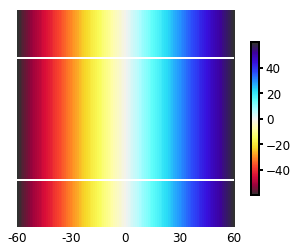

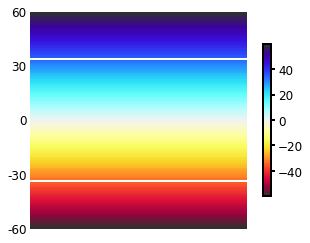

In [15]:
# # Load colormap
cmap_name = 'nic_Edge'
# zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=True, 
                                                   return_cmap=True)

# Set output dirs

In [16]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Metadata

In [17]:
# Get all data sets
traceid='traces001'

sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)
retinodata = sdata[sdata['experiment']=='retino'].copy()
retinodata.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum,datakey
visual_area,,,,,,
Li,23,23,23,23,23,23
Lm,19,19,19,19,19,19
V1,15,15,15,15,15,15


In [18]:
# screen info
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

# Example FOV ----------------------------------------------------------------------

In [22]:
curr_visual_area='V1'
retinodata[retinodata['visual_area']==curr_visual_area]

,animalid,experiment,fov,session,visual_area,fovnum,datakey
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1,20190522_JC084_fov1
41,JC085,retino,FOV1_zoom2p0x,20190622,V1,1,20190622_JC085_fov1
69,JC097,retino,FOV2_zoom2p0x,20190615,V1,2,20190615_JC097_fov2
74,JC097,retino,FOV1_zoom2p0x,20190617,V1,1,20190617_JC097_fov1
79,JC097,retino,FOV1_zoom2p0x,20190616,V1,1,20190616_JC097_fov1
84,JC097,retino,FOV1_zoom2p0x,20190613,V1,1,20190613_JC097_fov1
95,JC110,retino,FOV1_zoom2p0x,20191006,V1,1,20191006_JC110_fov1
97,JC110,retino,FOV2_zoom2p0x,20191004,V1,2,20191004_JC110_fov2
102,JC117,retino,FOV1_zoom2p0x,20191111,V1,1,20191111_JC117_fov1
123,JC076,retino,FOV1_zoom2p0x,20190420,V1,1,20190420_JC076_fov1


In [59]:
# animalid = 'JC097'
# session = '20190615'
# fovnum = 2

# fov = 'FOV%i_zoom2p0x' % fovnum
# traceid = 'traces001'

# datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# # Get retino runs
# found_retinoruns = [os.path.split(d)[-1] for d in 
#                     glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
# print("Found %i runs" % len(found_retinoruns))
# retinorun = found_retinoruns[0]

## Run step by step

In [152]:
# Load data metainfo
print("Current run: %s" % retinorun)
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
run_dir = RETID['DST'].split('/retino_analysis/')[0]
curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
    print("Saving output to:\n %s" % curr_dst_dir)
    
# Get run results
magratio, phase, trials_by_cond = ret_utils.fft_results_by_trial(RETID)

d2 = scaninfo['pixels_per_line']
d1 = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1, d2))

# Get ROIID and projection image
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

# Get pixel size
pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)


Current run: retino_run1
FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC089_20190522_FOV1_zoom2p0x_retino_run1_analysis001
Trials by cond:
{u'top': [3, 7, 9], u'right': [2, 4, 8], u'left': [11, 12, 5], u'bottom': [10, 1, 6]}
Original dims: [512, 512]
Data were downsampled by 2.


In [154]:
# pix_mag_thr=0.002

# abs_vmin, abs_vmax = (-np.pi, np.pi)
# absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
#                                                                                  mag_thr=pix_mag_thr, dims=(d1, d2),
#                                                                                  plot_conditions=False, ds_factor=ds_factor)

# np.nanmin(absolute_az), np.nanmax(absolute_az)

# fig, ax = pl.subplots()
# im0 = ax.imshow(absolute_az, cmap=cmap_phase)
# putils.colorbar(im0)


('got phase:', 0.0018304377565243612, 6.2819541827458343)
('got absolute:', -2.8854420118898094, 2.8571934398743544)
('Delay:', 0.25632350740830034, 5.986520024133787)


('got phase:', 0.0018304377565243612, 6.2819541827458343)
('got absolute:', -2.8854420118898094, 2.8571934398743544)
('Delay:', 0.25632350740830034, 5.986520024133787)


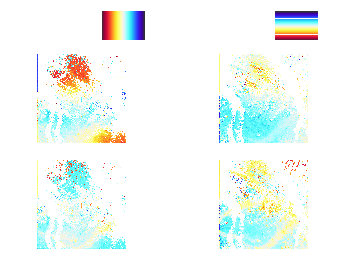

In [155]:
pix_mag_thr=0.002

abs_vmin, abs_vmax = (-np.pi, np.pi)
absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
                                                                                 mag_thr=pix_mag_thr, dims=(d1, d2),
                                                                                 plot_conditions=False, ds_factor=ds_factor)

shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, 
                                          oldmin=0, oldmax=2*np.pi)
shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, 
                                          oldmin=0, oldmax=2*np.pi)

fig = ret_utils.plot_phase_and_delay_maps(absolute_az, absolute_el, 
                                          shift_az_delay, shift_el_delay,
                                         cmap=cmap_phase, vmin=abs_vmin, vmax=abs_vmax)


#### Shift maps to match

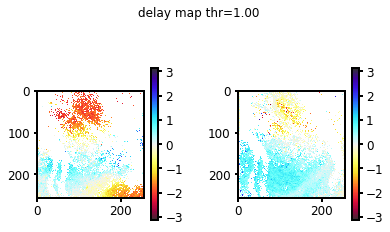

In [179]:
delay_map_thr=1

#shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)
#shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)

filt_az = np.where(abs(shift_az_delay)<delay_map_thr, absolute_az, np.nan)
filt_el = np.where(abs(shift_el_delay)<delay_map_thr, absolute_el, np.nan)

fig, axn = pl.subplots(1,2)
im0 = axn[0].imshow(filt_az, cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)
pl.colorbar(im0, ax=axn[0], shrink=0.7, orientation='vertical')
im1 = axn[1].imshow(filt_el, cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)
pl.colorbar(im1, ax=axn[1], shrink=0.7, orientation='vertical')

pl.suptitle("delay map thr=%.2f" % delay_map_thr)
pl.subplots_adjust(wspace=0.5)

#### Smooth

In [246]:
reload(grd)

<module 'pipeline.python.classifications.gradient_estimation' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/gradient_estimation.py'>

(u'/n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'pixelmaps_smooth-5_magthr-0.002_delaymapthr-1.00')


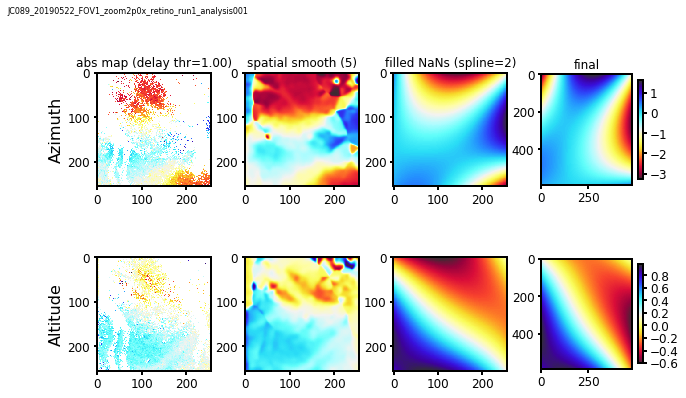

In [247]:
# Spatial smooth neuropil dilated masks 
smooth_spline=2 # Make larger if >1 area, use fill_and_smooth_nans_missing()
smooth_fwhm=5
use_phase_smooth=False

if use_phase_smooth:
    azim_smoothed = ret_utils.smooth_phase_nans(filt_az, smooth_fwhm,smooth_fwhm)
    elev_smoothed = ret_utils.smooth_phase_nans(filt_el, smooth_fwhm, smooth_fwhm)
else:
    azim_smoothed = ret_utils.smooth_neuropil(filt_az, smooth_fwhm=smooth_fwhm)
    elev_smoothed = ret_utils.smooth_neuropil(filt_el, smooth_fwhm=smooth_fwhm)

#azim_fillnan = grd.fill_and_smooth_nans(azim_smoothed, kx=nan_smooth, ky=nan_smooth)
#elev_fillnan = grd.fill_and_smooth_nans(elev_smoothed, kx=nan_smooth, ky=nan_smooth)
azim_fillnan = grd.fill_and_smooth_nans_missing(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
elev_fillnan = grd.fill_and_smooth_nans_missing(elev_smoothed, kx=smooth_spline, ky=smooth_spline)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_fillnan, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_fillnan, pixel_size, normalize=False)

az_fill = azim_r.copy()
el_fill = elev_r.copy()

vmin, vmax = (-np.pi, np.pi)

fig = grd.plot_retinomap_processing_pixels(filt_az, azim_smoothed, azim_fillnan, az_fill,
                                         filt_el, elev_smoothed, elev_fillnan, el_fill,
                                         cmap_phase=cmap_phase, vmin=vmin, vmax=vmax, \
                                           smooth_fwhm=smooth_fwhm, smooth_spline=smooth_spline,
                                         delay_map_thr=delay_map_thr, full_cmap_range=False)

putils.label_figure(fig, data_id)
figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)


In [233]:
reload(grd)

<module 'pipeline.python.classifications.gradient_estimation' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/gradient_estimation.pyc'>

In [19]:
retinodata[retinodata['animalid']=='JC080']

,animalid,experiment,fov,session,visual_area,fovnum,datakey
150,JC080,retino,FOV1_zoom2p0x,20190603,Lm,1,20190603_JC080_fov1
152,JC080,retino,FOV1_zoom2p0x,20190506,Lm,1,20190506_JC080_fov1
154,JC080,retino,FOV2_zoom2p0x,20190602,Lm,2,20190602_JC080_fov2
156,JC080,retino,FOV1_zoom2p0x,20190602,Li,1,20190602_JC080_fov1



# ----------------------------------
# MANUAL
# ----------------------------------

In [77]:
curr_visual_area='Li'
retinodata[retinodata['visual_area']==curr_visual_area].sort_values(by='animalid')

,animalid,experiment,fov,session,visual_area,fovnum,datakey
133,JC076,retino,FOV1_zoom2p0x,20190422,Li,1,20190422_JC076_fov1
156,JC080,retino,FOV1_zoom2p0x,20190602,Li,1,20190602_JC080_fov1
44,JC089,retino,FOV1_zoom2p0x,20190522,Li,1,20190522_JC089_fov1
55,JC090,retino,FOV1_zoom2p0x,20190605,Li,1,20190605_JC090_fov1
17,JC091,retino,FOV1_zoom2p0x,20191008,Li,1,20191008_JC091_fov1
23,JC091,retino,FOV1_zoom2p0x,20190607,Li,1,20190607_JC091_fov1
27,JC091,retino,FOV1_zoom2p0x,20190614,Li,1,20190614_JC091_fov1
31,JC091,retino,FOV1_zoom2p0x,20190606,Li,1,20190606_JC091_fov1
36,JC091,retino,FOV1_zoom2p0x,20190602,Li,1,20190602_JC091_fov1
47,JC092,retino,FOV3_zoom2p0x,20190527,Li,3,20190527_JC092_fov3


# Do it all in one go

In [78]:
datakey = '20190605_JC090_fov1'
session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])

# animalid = 'JC097'
# session = '20190613'
# fovnum = 1

fov = 'FOV%i_zoom2p0x' % fovnum
traceid = 'traces001'

datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# Get retino runs
found_retinodirs = glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))
found_retinoruns = [os.path.split(d)[-1] for d in found_retinodirs]
print("Found %i runs" % len(found_retinoruns))

# Set current animal's retino output dir
run_ix = 0
retinorun = found_retinoruns[run_ix]
curr_dst_dir = os.path.join(found_retinodirs[run_ix], 'retino_analysis', 'segmentation')
print(curr_dst_dir)

data_id = '_'.join([animalid, session, fov, retinorun, traceid])


Found 2 runs
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation


FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC090_20190605_FOV1_zoom2p0x_retino_run1_analysis001
('/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'elevation_pos_nic_Edge_LEGEND_abs')
Trials by cond:
{u'top': [12, 3, 7, 6], u'right': [13, 15, 14, 4], u'left': [11, 1, 2, 8], u'bottom': [10, 16, 5, 9]}
('got phase:', 0.0016047838649235757, 6.2828667338928383)
('got absolute:', -3.1015438703365632, 3.0666049335078434)
('Delay:', 0.13032390568728069, 6.2005031365176553)
... pixel size: (4.6, 3.8) (ds_factor=2.00)
(-2.1491154107166954, 1.7922279804433152)
(-1.0821425469654924, 0.92287535449449953)


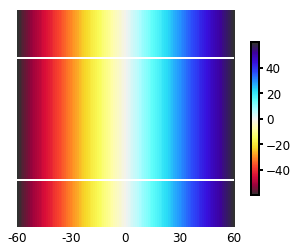

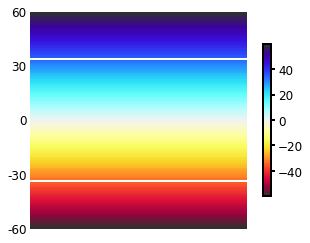

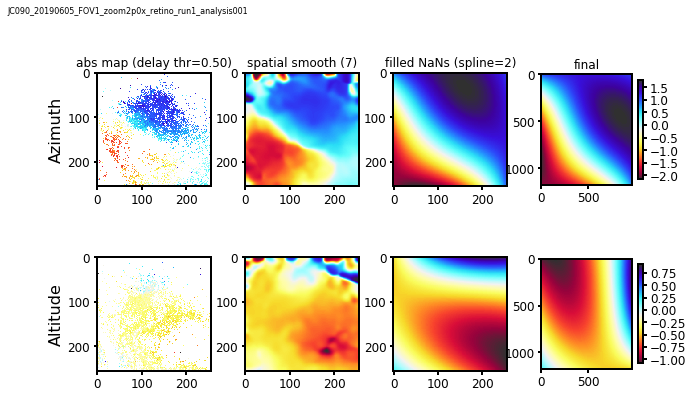

In [91]:
delay_map_thr = 0.5
pix_mag_thr = 0.002
smooth_fwhm = 7
smooth_spline=2
cmap_name = 'nic_Edge'
# ----------------------------------------------------------

az_fill, el_fill, params, RETID = grd.pixel_gradients(animalid, session, fov, traceid=traceid, retinorun=retinorun, 
                                                      mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr, 
                                                      dst_dir=curr_dst_dir, cmap=cmap_name, 
                                                      smooth_fwhm=smooth_fwhm, smooth_spline=smooth_spline,
                                                      full_cmap_range=False) 


## Get surface img

((512, 512), (1177, 972))


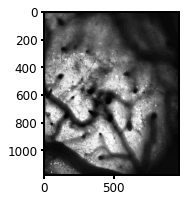

In [92]:
surface_img = ret_utils.load_2p_surface(animalid, session, fov, ch_num=1, retinorun=retinorun)
pixel_size = putils.get_pixel_size()
surface_2p = coreg.transform_2p_fov(surface_img, pixel_size, normalize=False)
surface_2p = putils.adjust_image_contrast(surface_2p, clip_limit=5.0, tile_size=5)
print(surface_img.shape, surface_2p.shape)

fig, ax = pl.subplots(figsize=(4,3))
ax.imshow(surface_2p, cmap='gray')

In [93]:
# if surface_img.shape[0] != absolute_az.shape[0]:
#     reduce_factor = surface_img.shape[0] / absolute_az.shape[0]
#     surface_img = block_reduce(surface_img, (2,2), func=np.mean)

# # transform to physical view
# surface_transf = coreg.orient_2p_to_macro(surface_img, zoom_factor=1., save=False, normalize=True)
# surface_r = coreg.scale_2p_fov(surface_transf, pixel_size=pixel_size)

# surface = putils.adjust_image_contrast(surface_r, clip_limit=2.0, tile_size=5)

# #print(surface_r.shape)
# f, ax = pl.subplots(figsize=(4,4))
# ax.imshow(surface)


# Convert to screen units

In [94]:
vmin=-np.pi
vmax=np.pi
img_az = putils.convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = putils.convert_range(el_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)   
print(vmin, vmax)

(-59.7782, 59.7782)


# Identify borders using the gradients


In [95]:
curr_dst_dir

'/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation'

# Segement areas

In [ ]:
# Segmenting params
sign_map_thr = 0.5
min_region_area = 500
# -------------------------------------------------------------------

O, S_thr = segment_areas(img_az, img_el, sign_map_thr=sign_map_thr, 
                         min_region_area=min_region_area, surface=surface_2p)
# Label image
region_props, labeled_image  = segment_and_label(S_thr)
region_labels = [region.label for region in region_props]
print('Found %i regions: %s' % (len(region_labels), str(region_labels)))

# Save
orig_d1, orig_d2 = surface_2p.shape
labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), (orig_d2, orig_d1)) #surface_2p.shape)
results = {'labeled_image_ds': labeled_image, 
           'labeled_image': labeled_image_2p,
           'region_props': region_props}


((1177, 972), (1177, 972, 3))
Found 6 regions: [1, 2, 3, 4, 5, 6]


In [ ]:
# Plot segmentation results
proc_info_str = 'pixthr=%.3f (delay thr=%.2f), smooth=%i' % (pix_mag_thr, delay_map_thr, smooth_fwhm)
fig = plot_segmentation_steps(img_az, img_el, surface=surface_2p, O=O, S_thr=S_thr, sign_map_thr=sign_map_thr, 
                               cmap=cmap_phase, labeled_image=labeled_image, region_props=region_props)

putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.subplots_adjust(hspace=0.5, bottom=0.2)
    
pl.savefig(os.path.join(curr_dst_dir, 'segemented_areas.png'))

# Select areas and label

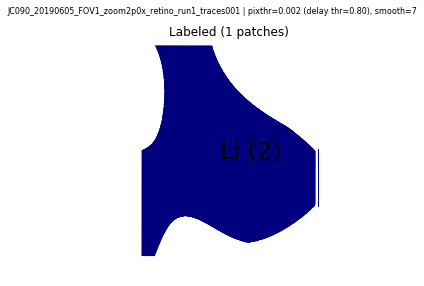

In [86]:
region_dict={2: 'Li'} #V1'}

seg_areas = {}
label_keys=[]
for ri, region in enumerate(region_props):
    region_id = region.label
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
        label_keys.append((region_name, region_id))
    else:
        region_name = region.label

    # save mask
    region_mask = np.copy(labeled_image.astype('float'))
    region_mask[labeled_image != region_id] = 0
    region_mask[labeled_image == region_id] = 1
    seg_areas[region_name] = {'id': region_id, 'mask': region_mask}
    

# double check labeling/naming of segmented areas
area_ids = [k[1] for k in label_keys]
labeled_image_incl = np.ones(labeled_image.shape)*np.nan #labeled_image.copy()
for idx in area_ids:
    labeled_image_incl[labeled_image==idx] = idx

fig, ax = pl.subplots()
ax.imshow(labeled_image_incl, cmap='jet')    
for region in region_props:
    if region.label in area_ids:
        region_name = str([k[0] for k in label_keys if k[1]==region.label][0])
        ax.text(region.centroid[1], region.centroid[0], 
                        '%s (%i)' % (region_name, region.label), fontsize=24, color='k')
    # plot
    contour = skmeasure.find_contours(labeled_image == region.label, 0.5)[0]
    ax.plot(contour[:, 1], contour[:, 0], 'w', lw=5)
ax.set_title('Labeled (%i patches)' % len(area_ids))
ax.axis('off')
putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.savefig(os.path.join(curr_dst_dir, 'labeled_areas.png'))

## Save results

In [87]:
# Load data metainfo
print("Current run: %s" % retinorun)
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Get ROIID and projection image
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)


segparams_fpath = os.path.join(curr_dst_dir, 'params.json')
segresults_fpath = os.path.join(curr_dst_dir, 'results.pkl')

seg_params = {'pixel_mag_thr': pix_mag_thr,
              'downsample_factor': ds_factor,
              'delay_map_thr': delay_map_thr,
              'smooth_fwhm': smooth_fwhm,
              'smooth_spline': smooth_spline,
              'sign_map_thr': sign_map_thr,
              'min_region_area': min_region_area,
              'retino_id': retinoid, 
              'retino_run': retinorun}

results.update({'areas': seg_areas})
results.update({'label_keys': label_keys})

with open(segparams_fpath, 'w') as f:
    json.dump(seg_params, f, indent=4, sort_keys=True)
    
with open(segresults_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

Current run: retino_run1
FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC090_20190605_FOV1_zoom2p0x_retino_run1_analysis001
Data were downsampled by 2.


#### Test w/ morphological steps


In [88]:
# nozeros = S.copy()

# k1 = 3
# niter = 3
# kernel =  np.ones((k1, k1))
# closing_s1 = cv2.morphologyEx(S, cv2.MORPH_CLOSE, kernel, iterations=niter)

# k2 = 3
# niter=3
# kernel = np.ones((k2, k2))
# opening_1 = cv2.morphologyEx(closing_s1, cv2.MORPH_OPEN, kernel, iterations=niter)

# k3 = 3
# niter = 3
# kernel = np.ones((k3, k3))
# #dilation = cv2.dilate(opening_1, kernel, iterations=niter)
# dilation = cv2.morphologyEx(opening_1, cv2.MORPH_CLOSE, kernel, iterations=niter)

# #nozeros[S==0] = np.nan
# test_sm = grd.fill_nans(dilation)
# f, ax = pl.subplots() #pl.figure()
# im=ax.imshow(test_sm, cmap='jet')
# putils.colorbar(im)

# Do stuff with segementations

## Calculate gradient for segmented areas

In [89]:
seg_results = load_segmentation_results(animalid, session, fov, retinorun=retinorun)
segmented_areas = seg_results['areas']
region_props = seg_results['region_props']

('/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'gradients_Li')


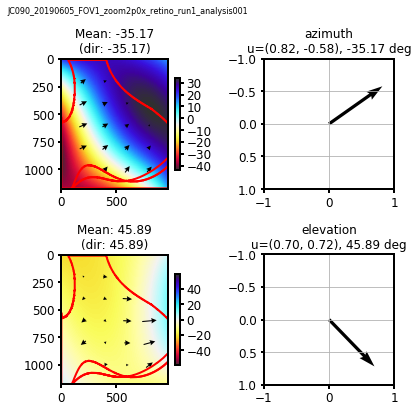

In [90]:
contour_color='r'
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

for curr_visual_area, area_results in segmented_areas.items():
    if putils.isnumber(curr_visual_area):
        continue
    curr_segmented_mask = area_results['mask']
    grad_az, grad_el = get_gradients_in_area(curr_segmented_mask, img_az, img_el)
    
    # Plot results ------------
    fig = plot_gradients_in_area(labeled_image, img_az, img_el, grad_az, grad_el, cmap_phase=cmap_phase,
                                 contour_color=contour_color, spacing=spacing, 
                                 scale=scale, width=width, headwidth=headwidth)
    pl.subplots_adjust(wspace=0.5, hspace=0.5)
    putils.label_figure(fig, data_id)

    figname = 'gradients_%s' % curr_visual_area
    pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
    print(curr_dst_dir, figname)


## Assign cells to visual area(s)

# Load data

In [73]:
#### Get roi masks 
traceid= 'traces001'
roi_id = None
if roi_id is None:
    roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
r_masks, zprog_img = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
print("Loaded rois: %s" % roi_id)
d1, d2, nrois = r_masks.shape

##### Reshape and transform to match 'natural view'
pixel_size = putils.get_pixel_size() #* ds_factor
roi_masks_tr = np.dstack([coreg.transform_2p_fov(r_masks[:, :, i].astype(float), pixel_size) \
               for i in np.arange(0, nrois)]) # transform/orient
roi_masks = roi_masks_tr.astype(bool).astype(int)
print(roi_masks.shape)

Loaded rois: rois002
(1177, 972, 183)


## Load segmentation results

In [74]:
seg_results = load_segmentation_results(animalid, session, fov, retinorun=retinorun)
seg_areas = seg_results['areas']

## Assign roi IDs to visual area

Assigning rois to visual areas...
Loaded rois: rois002
('Roi masks:', 1177, 972, 183)
plotting assigned rois
(0, 5)


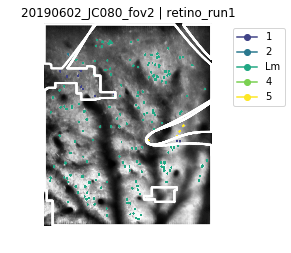

In [75]:
id_cmap='viridis'

return_labeled_masks=True
verbose=False
create_new = True

if not create_new:
    try:
        print("Loading roi assignments")
        roi_assignments, roi_masks_labeled = load_roi_assignments(animalid, session, fov, retinorun=retinorun)
    except AssertionError:
        create_new=True

plot_rois = create_new

if create_new:
    print("Assigning rois to visual areas...")
    roi_assignments, roi_masks_labeled = assign_rois_to_visual_area(animalid, session, fov, 
                                                        retinorun=retinorun, traceid=traceid,
                                                        return_labeled_masks=return_labeled_masks, verbose=verbose)

    # Save
#     assignment_results = {'roi_assignments': roi_assignments, 'roi_masks_labeled': roi_masks_labeled.astype(int)}
#     assignments_fpath = os.path.join(curr_dst_dir, 'roi_assignments.pkl')
#     with open(assignments_fpath, 'wb') as f:
#         pkl.dump(assignment_results, f, protocol=pkl.HIGHEST_PROTOCOL)

    # Save assignments
    assignments_fpath = os.path.join(curr_dst_dir, 'roi_assignments.json')
    with open(assignments_fpath, 'w') as f:
        json.dump(roi_assignments, f, indent=4)
    create_new=False

if plot_rois:
    print("plotting assigned rois")
    f, ax = pl.subplots(figsize=(3,4))
    plot_segmented_rois(seg_results, roi_assignments, roi_masks_labeled, cmap=id_cmap, surface=surface_2p, ax=ax)
    putils.label_figure(fig, data_id)
    ax.set_title('%s | %s' % (datakey, retinorun))
    pl.savefig(os.path.join(curr_dst_dir, 'assigned_rois.svg'))


plotting assigned rois
(0, 4)


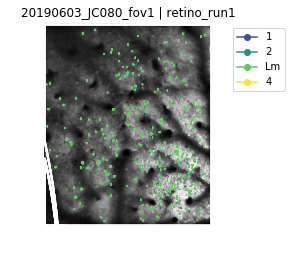

In [37]:

if plot_rois:
    print("plotting assigned rois")
    f, ax = pl.subplots(figsize=(3,4))
    plot_segmented_rois(seg_results, roi_assignments, roi_masks_labeled, cmap=id_cmap, surface=surface_2p, ax=ax)
    putils.label_figure(fig, data_id)
    ax.set_title('%s | %s' % (datakey, retinorun))
    pl.savefig(os.path.join(curr_dst_dir, 'assigned_rois.svg'))
